# Restaurant Recommendation System

### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
from sqlite3 import dbapi2 as sq3
from pathlib import Path
from collections import OrderedDict

from time import time
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [ ]:
REVIEW_PATH = '/content/drive/MyDrive/yelp_dataset/yelp_academic_dataset_review.json'      #Contains full review text data including the user_id that wrote the review and the business_id the review is written for.
BUSINESS_PATH = '/content/drive/MyDrive/yelp_dataset/yelp_academic_dataset_business.json'  #Contains business data including location data, attributes, and categories.
USER_PATH = '/content/drive/MyDrive/yelp_dataset/yelp_academic_dataset_user.json'          #User data including the user's friend mapping and all the metadata associated with the user.

# Functions to load data from json format
#ref: https://www.kaggle.com/hexianwang/yelp-data
def load_rows(file_path, nrows=None, only_return_count=False, verbose=True):
    """
    Returns dataframe from json file
    """
    tic = time()
    with open(file_path) as json_file:
        count = 0
        objs = []
        line = json_file.readline()
        while (nrows is None or count<nrows) and line:
            count += 1
            if not only_return_count:
                obj = json.loads(line)
                objs.append(obj)
            line = json_file.readline()
        toc = time()
        if verbose:
            print(file_path.split('/')[-1], 'loaded. Count =', count, ', Time =', round(toc-tic,2), 'secs.')
        
        if only_return_count:
            return count
        
        return pd.DataFrame(objs)
    
    
#data generator to load data in chunks
def load_rows_gen(file_path, nrows=1e6, verbose=True):
    """
    Returns data in chunks
    """
    with open(file_path) as json_file:
        line = json_file.readline()
        total = 0
        while line:
            count = 0
            objs = []
            tic = time()
            while count<nrows and line:
                count+=1
                obj = json.loads(line)
                objs.append(obj)
                line = json_file.readline()
                total += count
            toc = time()
            print('Loaded chunk of size:', count, ", Time =", round(toc-tic,2), 'secs.')
            yield pd.DataFrame(objs)

### Looking at data

In [ ]:
user_df_head = load_rows(USER_PATH, 5)
user_df_head

In [ ]:
review_df_head = load_rows(REVIEW_PATH, 5)
review_df_head

In [ ]:
business_df_head = load_rows(BUSINESS_PATH, 5)
business_df_head.head()

### Creating SQLite database
As data size is more than what the RAM can handle.

In [ ]:
# Functions to work with db2api from sqlite3

PATHSTART = "."
def get_db(dbfile):
    #get connection to db
    sqlite_db = sq3.connect(Path(PATHSTART)/ dbfile)
    return sqlite_db

def init_db(dbfile, schema):
    #create db a/c to schema
    db = get_db(dbfile)
    
    #execute sql code
    c = db.cursor()
    c.executescript(schema)
    
    #make commit
    db.commit()
    return db

def make_query(sel):
    c = db.cursor().execute(sel)
    return c.fetchall()

from collections import OrderedDict
def make_frame(list_of_tuples, legend):
    framelist=[]
    for i, cname in enumerate(legend):
        framelist.append((cname,[e[i] for e in list_of_tuples]))
    return pd.DataFrame.from_dict(OrderedDict(framelist)) 

In [ ]:
#Table Schema for tables in our SQLite database

users_schema = """
DROP TABLE IF EXISTS "users";

CREATE TABLE "users" (
    "user_id" INTEGER PRIMARY KEY NOT NULL,
    "name" VARCHAR,
    "review_count" INTEGER,
    "yelping_since" TIMESTAMP,
    "useful" INTEGER,
    "funny" INTEGER,
    "cool" INTEGER,
    "elite" VARCHAR,
    "friends" VARCHAR,
    "fans" INTEGER,
    "average_stars" FLOAT,
    "compliment_hot" INTEGER,
    "compliment_more" INTEGER, 
    "compliment_profile" INTEGER,
    "compliment_cute" INTEGER,
    "compliment_list" INTEGER,
    "compliment_note" INTEGER,
    "compliment_plain" INTEGER,
    "compliment_cool" INTEGER,
    "compliment_funny" INTEGER,
    "compliment_writer" INTEGER,
    "compliment_photos" INTEGER
);
"""
businesses_schema="""
DROP TABLE IF EXISTS "businesses";

CREATE TABLE "businesses" (
    "business_id" INTEGER PRIMARY KEY NOT NULL,
    "name" VARCHAR,
    "address" VARCHAR,
    "city" VARCHAR,
    "state" VARCHAR,
    "postal_code" VARCHAR,
    "latitude" FLOAT,
    "longitude" FLOAT,
    "stars" FLOAT,
    "review_count" INTEGER,
    "is_open" BOOLEAN,
    "categories" VARCHAR,
"""
reviews_schema = """
DROP TABLE IF EXISTS "reviews";

CREATE TABLE "reviews" (
    "review_id" VARCHAR PRIMARY KEY,
    "user_id" INTEGER,
    "business_id" INTEGER,
    "stars" FLOAT,
    "useful" INTEGER,
    "funny" INTEGER,
    "cool" INTEGER,
    "text"  VARCHAR,
    "date" TIMESTAMP,
    
    
    FOREIGN KEY (user_id) REFERENCES users(user_id),
    FOREIGN KEY (business_id) REFERENCES businesses(business_id)
);
"""
schema_close = ");"

In [ ]:
#Load data about all businesses
business_df = load_rows(BUSINESS_PATH)
business_df.head()

yelp_academic_dataset_business.json loaded. Count = 160585 , Time = 4.69 secs.


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Antiques, Fashion, Used, Vintage & Consignment...","{'Thursday': '11:0-18:0', 'Friday': '11:0-18:0..."
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Beauty & Spas, Hair Salons",None
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,"{'GoodForKids': 'False', 'BusinessParking': '{...","Gyms, Active Life, Interval Training Gyms, Fit...","{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'..."


In [ ]:
%%time

#Here we preprocess our businesses data
def preprocess_business_df(df):
    """
    Preprocess data from BUSINESS_PATH
    returns final DataFrame
    """
    #mask to only select businesses which are either Restaurant or serve Food
    mask = df.categories.str.contains('Restaurant', na=False) | df.categories.str.contains('Food', na=False)
    df = df[mask]
    #Changing business_id to numbers
    global businessid_to_idx
    businessid_to_idx = {b_id : idx for idx, b_id in enumerate(df.business_id.unique())}
    df.business_id = df.business_id.map(lambda x: businessid_to_idx[x])

    #TDT
    df.is_open = df.is_open.astype(bool)

    # Exploding attributes [MultiCategorization]
    attr = [col for col in df.attributes.explode().unique() if col is not None]
    lst_of_attr_dict = []
    for attr_dict in df.attributes:
        if not attr_dict:
            lst_of_attr_dict.append({})
            continue

        if 'BusinessParking' in attr_dict:
            if type(attr_dict['BusinessParking']) == str:
                attr_dict['BusinessParking'] = ('True' in attr_dict['BusinessParking'])

        lst_of_attr_dict.append(attr_dict)
    
    attr_df = pd.DataFrame(lst_of_attr_dict, columns=attr)
    for col in attr_df:
        #Handling missing
        #Strategy -> absence of attribute means restauratn doesn't have it
        #ex. If parking is null then restaurant doesn't have parking
        attr_df[col] = attr_df[col].fillna(False).astype(bool)
    
    df = pd.concat([df.reset_index().drop('index', axis=1), attr_df], axis=1)
    df.drop(['attributes'], axis=1, inplace=True)
    
    #Exploding hours ie. getting opening and closing time for various days
    lst_of_time = []
    for time_dict in df.hours:
        if not time_dict:
            lst_of_time.append({})
            continue
        lst_of_time.append(time_dict)
    time_df = pd.DataFrame(lst_of_time)
    df = pd.concat([df, time_df], axis=1).drop('hours', axis=1)
    
    return df

business_df = preprocess_business_df(business_df)
business_df.head()

CPU times: user 2.82 s, sys: 15.9 ms, total: 2.84 s
Wall time: 2.84 s


In [ ]:
# Looking at overview of our data
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63915 entries, 0 to 63914
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 63915 non-null  int64  
 1   name                        63915 non-null  object 
 2   address                     63915 non-null  object 
 3   city                        63915 non-null  object 
 4   state                       63915 non-null  object 
 5   postal_code                 63915 non-null  object 
 6   latitude                    63915 non-null  float64
 7   longitude                   63915 non-null  float64
 8   stars                       63915 non-null  float64
 9   review_count                63915 non-null  int64  
 10  is_open                     63915 non-null  bool   
 11  categories                  63915 non-null  object 
 12  RestaurantsTableService     63915 non-null  bool   
 13  WiFi                        639

In [ ]:
# Completing Business Table Schema
for bool_col in business_df.columns[12:51]:
    businesses_schema += '    \"' + bool_col + '\"' + ' BOOLEAN,\n'
for day in business_df.columns[51:]:
    businesses_schema += '    \"' + day + '\"' + ' VARCHAR,\n'
    
businesses_schema = businesses_schema[:-2] + schema_close

In [ ]:
%%time
#Create db
db = init_db("./yelp_database_new.db", users_schema+businesses_schema+reviews_schema)

#business data to sql
business_df.to_sql('businesses', db, if_exists='append', index=False)

#release memory
del business_df

CPU times: user 3.85 s, sys: 97 ms, total: 3.94 s
Wall time: 4.1 s


In [ ]:
def preprocess_user_df(df):
    global userid_to_idx
    userid_to_idx = {user : idx for idx, user in enumerate(df.user_id.unique())}
    df.user_id = df.user_id.map(lambda x: userid_to_idx[x])
    df.friends = df.friends.map(lambda x : str([userid_to_idx[user] for user in x.split(',') if user in userid_to_idx]))
    df.yelping_since = pd.to_datetime(df.yelping_since)
    df.elite = df.elite.replace('', np.nan)
    return df

In [ ]:
#load data about users
user_df = load_rows(USER_PATH)
user_df.head()

In [ ]:
user_df.info()

In [ ]:
del user_df

In [ ]:
%%time
#Here we load data from reviews

#size of review.json overpowers RAM hence we'll process data in chunks and store it to table
for data in load_rows_gen(REVIEW_PATH):
    #transformations
    data.user_id = data.user_id.apply(lambda key : userid_to_idx[key] if key in userid_to_idx else np.nan)
    data.business_id = data.business_id.apply(lambda key : businessid_to_idx[key] if key in businessid_to_idx else np.nan)
    data.date = pd.to_datetime(data.date)
    data.dropna(inplace=True)
    #sending chunk to sql
    data.to_sql('reviews', db, if_exists='append', index=False)

In [ ]:
#Looking at last chunk
data.head()

In [ ]:
data.info()

In [ ]:
#Release memory
del data

In [ ]:
def make_query(sel):
    c = db.cursor().execute(sel)
    return c.fetchall()

def make_frame(list_of_tuples, legend):
    framelist=[]
    for i, cname in enumerate(legend):
        framelist.append((cname,[e[i] for e in list_of_tuples]))
    return pd.DataFrame.from_dict(OrderedDict(framelist))

In [ ]:
q = make_query("SELECT user_id, business_id, stars FROM reviews")
ratings_df = make_frame(q, legend=['user_id', 'business_id', 'stars'])
del q
ratings_df.head()

In [ ]:
ratings_df.to_csv('ratings.csv')

In [ ]:
sns.catplot(data=ratings_df, x='stars', kind='count', aspect=2)

###Creating the Model

In [ ]:
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import pydot
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from operator import itemgetter
from sklearn.decomposition import PCA
%matplotlib inline

2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ratings.csv")

In [ ]:
df.head()

,Unnamed: 0,user_id,business_id,stars
0,0,92669,1150,4.0
1,1,102147,6047,4.0
2,2,147370,1918,2.0
3,3,2416,1417,4.0
4,4,59423,342,1.0


In [ ]:
np.random.seed=2017
train_indices, val_indices = train_test_split(range(df.shape[0]), train_size=0.8)
trdf = df.iloc[train_indices]
valdf = df.iloc[val_indices]
trdf.shape, valdf.shape

((3973925, 4), (993482, 4))

In [ ]:
L = 50
REG = 1e-2

In [ ]:
def create_bias(name, inp, n_in, reg):
    #x = Embedding(n_in, 1, input_length=1, embeddings_regularizer=l2(reg))(inp)
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flat')(x)

In [ ]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

In [ ]:
nusers = df.user_id.nunique()
nrestaurants = df.business_id.nunique()
nusers, nrestaurants

(822726, 63891)

In [ ]:
user_input, uLmat = embedding_input('user_input', nusers, L, REG)
restaurant_input, rLmat = embedding_input('restaurant_input', nrestaurants, L, REG)

In [ ]:
user_input.shape, restaurant_input.shape

(TensorShape([None, 1]), TensorShape([None, 1]))

In [ ]:
uLmat.shape, rLmat.shape

(TensorShape([None, 1, 50]), TensorShape([None, 1, 50]))

In [ ]:
user_bias = create_bias('user_bias', user_input, nusers, REG)
restaurant_bias = create_bias('restaurant_bias', restaurant_input, nrestaurants, REG)

In [ ]:
user_bias.shape, restaurant_bias.shape

(TensorShape([None, 1]), TensorShape([None, 1]))

In [ ]:
residual = Dot(axes=2, name="residual")([uLmat, rLmat])

In [ ]:
residual.shape

TensorShape([None, 1, 1])

In [ ]:
residflat = Flatten(name="residual_flat")(residual)
residflat.shape

TensorShape([None, 1])

In [ ]:
regression = Add(name="regression")([user_bias, restaurant_bias, residflat])

In [ ]:
regression.shape

TensorShape([None, 1])

In [ ]:
def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low
    return custom_sigmoid

In [ ]:
cs = sigmoid_maker(0, 5.5)

In [ ]:
output = Activation(cs, name="Sigmoid_Range")(regression)

In [ ]:
model = Model([user_input, restaurant_input], output)
model.compile(Adam(0.01), loss='mse')

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 restaurant_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 user_factor (Embedding)        (None, 1, 50)        41136300    ['user_input[0][0]']             
                                                                                                  
 restaurant_factor (Embedding)  (None, 1, 50)        3194550     ['restaurant_input[0][0]']       
                                                                                            

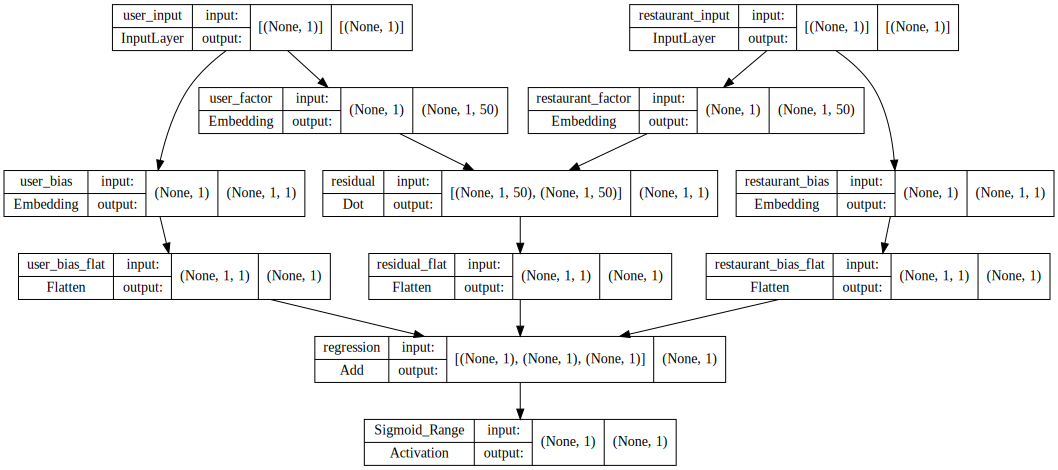

In [ ]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, dpi=72, rankdir='TB').create_svg())

###Training the Model

In [ ]:
model.optimizer.learning_rate = 5e-2
history = model.fit([trdf.user_id, trdf.business_id], trdf.stars, epochs=2, 
          validation_data=([valdf.user_id, valdf.business_id], valdf.stars), batch_size=1024, verbose=1)

Epoch 1/2
3881/3881 [==============================] - 156s 39ms/step - loss: 3.2834 - val_loss: 2.9045
Epoch 2/2
3881/3881 [==============================] - 154s 40ms/step - loss: 2.6865 - val_loss: 2.9861


In [ ]:
model.save_weights("/content/drive/MyDrive/cf.h5")

Text(0.5, 1.0, 'Training vs Validation Loss')

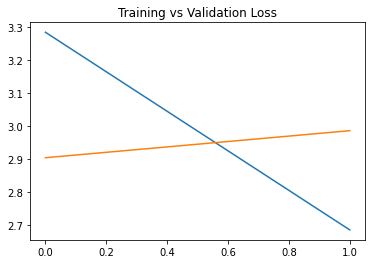

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training vs Validation Loss')

In [ ]:
model.predict([np.array([3]), np.array([458])])

array([[5.0736294]], dtype=float32)

In [ ]:
preds_df = df[['business_id', 'stars', 'user_id']].copy()
preds_df['predictions'] = model.predict([preds_df.user_id, preds_df.business_id]).ravel()

In [ ]:
preds_df.to_csv("/content/drive/MyDrive/preds.csv")

###Comparing Predicted ratings to Actual ratings

In [ ]:
preds_stats=preds_df.groupby('stars')['predictions'].describe().reset_index()
preds_stats

,stars,count,mean,std,min,25%,50%,75%,max
0,1.0,480980.0,2.591992,1.487977,0.002329,1.243266,2.573628,3.885845,5.494643
1,2.0,456524.0,3.220758,1.279656,0.014621,2.268134,3.393028,4.271964,5.492524
2,3.0,695309.0,3.650443,1.101361,0.006816,2.951496,3.845617,4.518595,5.493388
3,4.0,1408153.0,4.035759,0.978840,0.010890,3.508380,4.255637,4.780721,5.496568
4,5.0,1926441.0,4.503384,0.881844,0.016825,4.151856,4.771025,5.135151,5.499292


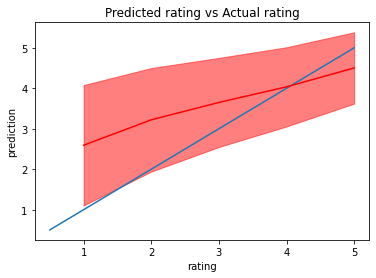

In [ ]:
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats["stars"], preds_stats['mean'], color="red")
plt.fill_between(preds_stats["stars"], preds_stats['mean']-preds_stats['std'], preds_stats['mean']+preds_stats['std'], color="red", alpha=0.5)
plt.xlabel("rating")
plt.ylabel("prediction")
plt.title("Predicted rating vs Actual rating")
plt.show()

In [ ]:
ct = pd.crosstab(preds_df.stars.astype('category'), 
                 preds_df.predictions.apply(lambda x: round(x*2)/2).astype('category'))
ct

predictions,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5
stars,,,,,,,,,,,,
1.0,12278,52881,55830,47602,43865,43154,44573,47320,48901,46533,32236,5807
2.0,1637,14189,25269,32266,39249,45740,53046,61173,66815,65128,45261,6751
3.0,535,6531,15235,25964,39413,57161,79014,101692,123625,133004,98759,14376
4.0,403,5451,13795,26162,44265,70644,111614,172323,256053,333257,315023,59163
5.0,526,4717,10524,17701,28867,45961,75256,127735,224963,403786,683542,302863


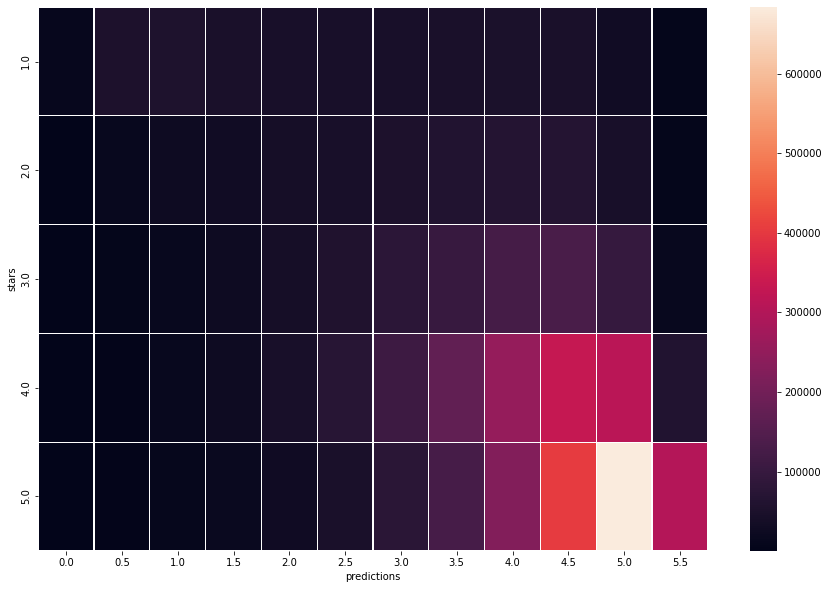

In [ ]:
plt.figure(figsize = (15,10))
sns.heatmap(ct, linewidths=0.1)

The model does well in the 4-5 region

###Recommending restaurants

In [ ]:
table = make_query("SELECT business_id, name, address, city, state, postal_code, latitude, longitude, stars\
                   FROM businesses")
business_df = make_frame(table, "business_id, name, address, city, state, postal_code, latitude, longitude, stars".split(', '))

del table

In [ ]:
def generate_candidates(user_id, friend=False):
    """
    Returns list of business id's which could be good prospects for a particular user.
    Factors in location.
    
    Parameters:
    user_id : id of user
    
    Return:
    lst : list of restaurant ids. Is not empty
    """
    lst = []
    top_candidates_by_city = 20
    # By Location
    #all the restaurants user has been to previously
    user_history = df.query(f'user_id=={user_id}')
    if user_history.shape[0]!=0:
        # Details about those restaurants
        visit_history = business_df.query(f'business_id in {list(user_history.business_id)}')
        # Implying city user lives in by looking at most frequent city in history
        # This will allow our recommendation to personalize recommendations for user
        city_mode = visit_history.city.mode()
        for city in city_mode:
          city_df = business_df.query(f'city == "{city}"').sort_values(by='stars')[:400]
          lst.extend(city_df.business_id[:top_candidates_by_city].values)        
    if lst:
        return list(set(lst))

    return boring_user()

def boring_user():
    """
    A user is boring if he has not rated any restaurants. For such users 
    candidates are generated based on restaurant restaurant biases. 
    This could be a new user on site who hasn't interacted much. 
    
    Return:
    lst : list of restaurant ids. Is not empty
    """
    return_top = 20
    restaurant_bias = model.get_layer('restaurant_bias').weights[0].numpy()
    bias_df = pd.DataFrame(restaurant_bias, columns=['restaurant_bias'])
    bias_df.index.name='business_id'
    bias_df = bias_df.sort_values(by='restaurant_bias', ascending=False)

    return bias_df.index[:return_top].tolist()


In [ ]:
def recommend(user_id, top=10):
    """
    Uses Recommendation system to recommend restaurant to user.
    
    Parameters:
    user_id : id of user
    top : Number of recommendations [10 by default]
    
    Returns:
    id_lst : List of business ids. List size = top 
    pred_ratings : List of ratings for corresponding business id. List size = top
    """
    
    label = f"predicted_rating_user_id_{user_id}"
    candidates = generate_candidates(user_id=user_id)
    pred_ratings = model.predict([np.array([user_id]*len(candidates)), np.array(candidates)])
    pred_df = pd.DataFrame({'business_id':candidates, label:pred_ratings.ravel()})
    df = business_df.query(f'business_id in {candidates}')
    return df.merge(pred_df, on='business_id').sort_values(by=label, ascending=False).head(top)

In [ ]:
recommend(user_id=999, top=5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,predicted_rating_user_id_999
27,35885,O'Brian's Liquors,158 Highland Ave,Somerville,MA,02143,42.388432,-71.103793,2.5,3.809033
18,23010,McDonald's,702 Washington St,Boston,MA,02111,42.351145,-71.062697,1.5,3.668192
17,22856,7-Eleven,532 Commonwealth,Boston,MA,02215,42.348476,-71.096326,1.5,3.538559
10,15430,Rite Aid,299 Broadway,Somerville,MA,02145,42.393026,-71.092546,2.5,3.233043
33,46167,McDonald's,14 Mcgrath Hwy,Somerville,MA,02143,42.373708,-71.082889,2.0,3.230029
